In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
import re
import os
import matplotlib
import matplotlib.pyplot as plt #导入matplotlib.pyplot画图模块
import numpy as np
plt.rcParams['font.sans-serif']='SimHei' #设置中文显示
plt.rcParams['axes.unicode_minus']=False
from collections import defaultdict
word_pat = re.compile('(\w+)')
function_node_address_pat = re.compile('(\d+\\.\d+\\.\d+\\.\d+)')
num_pat = re.compile('(\d+)')
log_name = "2.0-commit--8-10-5.29.log"
fp =open(f"..\\log\\{log_name}", encoding='UTF-8')
log_name = log_name
if not os.path.exists(log_name):
    os.makedirs(log_name)

In [3]:
total_request = 0
total_success_request = 0
all_request_dic = defaultdict(list)

function_name = None
lines = fp.readlines()
# lines = lines[len(lines) - 24455:]
n = len(lines)
# RequestStatus 分析
for i in range(n): 
    if "request function name:" in lines[i]:
        total_request += 1
    function_name_list = word_pat.findall(lines[i])
    if "FunctionName" in function_name_list:
        request_dic = {}
        if "local" in log_name:
            function_name = function_name_list[1]
            request_dic["container_id"] = word_pat.findall(lines[i + 2])[1]
        else:
            function_name = function_name_list[2]
            request_dic["container_id"] = word_pat.findall(lines[i + 2])[2]
        total_success_request += 1
        request_dic["node_address"] = function_node_address_pat.findall(lines[i + 1])[0]
        request_dic["schedule_acquire_container_latency"] = int(num_pat.findall(lines[i + 3])[0])
        request_dic["schedule_return_container_latency"] = int(num_pat.findall(lines[i + 4])[0])
        request_dic["function_execution_duration"] = int(num_pat.findall(lines[i + 5])[0])
        request_dic["response_time"] = int(num_pat.findall(lines[i + 6])[0])
        request_dic["require_memory"] = int(num_pat.findall(lines[i + 7])[0]) // 1024 ** 2
        request_dic["max_memory_usage"] = int(num_pat.findall(lines[i + 8])[0]) // 1024 ** 2
        request_dic["actual_require_memory"] = int(num_pat.findall(lines[i + 9])[0]) // 1024 ** 2
        request_dic["function_timeout"] = int(num_pat.findall(lines[i + 10])[0]) // 1024 ** 2
        all_request_dic[function_name].append(request_dic)

# 函数特性分析
function_request_frequency = {}
time_division_pat = re.compile('(\w+)')
for i in all_request_dic:
    now_frequency = 0
    pre_time = ""
    if "local" in log_name:
        pat = re.compile(f'Time=2020-08(.*) request id.*request function name: {i}')
    else:
        pat = re.compile(f'Time=2020-08(.*) request id.*request function name: {i}\\\\r')
    # (次数，延迟（秒）)
    frequency_list = []
    interval_list = []
    for line in lines:
        now_time = pat.findall(line)
        if now_time:
            now_time = now_time[0]
            if not pre_time:
                pre_time = now_time
                now_frequency += 1
            else:
                # 间隔计算 单位ms
                request_time1 = time_division_pat.findall(pre_time)
                request_time2 = time_division_pat.findall(now_time)
                if request_time2[1] < request_time1[1]:
                    request_time2[1] = int(request_time2[1])+ 60
                time_interval = (int(request_time2[1]) - int(request_time1[1])) * 60 * 1000 + (int(request_time2[2]) - int(request_time1[2])) *1000 + (int(request_time2[3]) - int(request_time1[3]))
            
                if time_interval <= 100:
                    now_frequency += 1
                else:
                    frequency_list.append(now_frequency)
                    interval_list.append(time_interval)
                    
                    pre_time = now_time
                    now_frequency = 1
                    
    # 添加最后一次的次数
    frequency_list.append(now_frequency)
    
    function_request_frequency[i] = {"frequency": frequency_list, "interval": interval_list}
    
# 计算总执行时间，单位秒
all_time_interval = 0
time_pat = re.compile('Time=.*T(.*\.\d\d\d) ')
request_time1 = time_pat.findall(lines[2])
request_time2 = time_pat.findall(lines[-1])
if request_time1 and request_time2:
    request_time1 = time_division_pat.findall(request_time1[0])
    request_time2 = time_division_pat.findall(request_time2[0])
    if request_time1[0] == "00":
        request_time1[0] = 24
    if request_time2[0] == "00":
        request_time2[0] = 24
    time1 = int(request_time1[0])*3600 + int(request_time1[1])*60 + int(request_time1[2])
    time2 = int(request_time2[0])*3600 + int(request_time2[1])*60 + int(request_time2[2])
    all_time_interval = int(time2 - time1)
                    
fp.close()
lines.clear()

In [4]:
function_name_list = list(all_request_dic.keys())
function_name_list.sort(key=lambda x: int(num_pat.findall(x)[0]))
function_analyze_result = []

# RequestStatus 分析
for i in function_name_list:
    
    # RequestStatus 分析
    max_schedule_acquire_container_latency = 0
    min_schedule_acquire_container_latency = float('inf')
    mean_schedule_acquire_container_latency = 0
    
    max_schedule_return_container_latency = 0
    min_schedule_return_container_latency = float('inf')
    mean_schedule_return_container_latency = 0
    
    max_function_execution_duration = 0
    min_function_execution_duration = float('inf')
    mean_function_execution_duration = 0
    
    max_response_time = 0
    min_response_time = float('inf')
    mean_response_time = 0
    
    max_require_memory = 0
    min_require_memory = float('inf')
    mean_require_memory = 0
    
    max_max_memory_usage = 0
    min_max_memory_usage = float('inf')
    mean_max_memory_usage = 0
    
    max_actual_require_memory = 0
    min_actual_require_memory = float('inf')
    mean_actual_require_memory = 0
    
    # RequestStatus 分析
    for j in all_request_dic[i]:
        max_schedule_acquire_container_latency = max(max_schedule_acquire_container_latency, j["schedule_acquire_container_latency"])
        min_schedule_acquire_container_latency = min(min_schedule_acquire_container_latency, j["schedule_acquire_container_latency"])
        mean_schedule_acquire_container_latency += j["schedule_acquire_container_latency"]
        
        max_schedule_return_container_latency = max(max_schedule_return_container_latency, j["schedule_return_container_latency"])
        min_schedule_return_container_latency = min(min_schedule_return_container_latency, j["schedule_return_container_latency"])
        mean_schedule_return_container_latency += j["schedule_return_container_latency"]
        
        max_function_execution_duration = max(max_function_execution_duration, j["function_execution_duration"])
        min_function_execution_duration = min(min_function_execution_duration, j["function_execution_duration"])
        mean_function_execution_duration += j["function_execution_duration"]
        
        max_response_time = max(max_response_time, j["response_time"])
        min_response_time = min(min_response_time, j["response_time"])
        mean_response_time += j["response_time"]
        
        max_require_memory = max(max_require_memory, j["require_memory"])
        min_require_memory = min(min_require_memory, j["require_memory"])
        mean_require_memory += j["require_memory"]
        
        max_max_memory_usage = max(max_max_memory_usage, j["max_memory_usage"])
        min_max_memory_usage = min(min_max_memory_usage, j["max_memory_usage"])
        mean_max_memory_usage += j["max_memory_usage"]
        
        max_actual_require_memory = max(max_actual_require_memory, j["actual_require_memory"])
        min_actual_require_memory = min(min_actual_require_memory, j["actual_require_memory"])
        mean_actual_require_memory += j["actual_require_memory"]
    
    result = {}
    n = len(all_request_dic[i])
    result["function_name"] = i
    result["request_num"] = n
    
    result["max_schedule_acquire_container_latency"] = max_schedule_acquire_container_latency
    result["min_schedule_acquire_container_latency"] = min_schedule_acquire_container_latency
    result["mean_schedule_acquire_container_latency"] = mean_schedule_acquire_container_latency // n
    
    result["max_schedule_return_container_latency"] = max_schedule_return_container_latency
    result["min_schedule_return_container_latency"] = min_schedule_return_container_latency
    result["mean_schedule_return_container_latency"] = mean_schedule_return_container_latency // n
    
    result["max_function_execution_duration"] = max_function_execution_duration
    result["min_function_execution_duration"] = min_function_execution_duration
    result["mean_function_execution_duration"] = mean_function_execution_duration // n
    
    result["max_response_time"] = max_response_time
    result["min_response_time"] = min_response_time
    result["mean_response_time"] = mean_response_time // n
    
    result["max_require_memory"] = max_require_memory
    result["min_require_memory"] = min_require_memory
    result["mean_require_memory"] = mean_require_memory // n
    
    result["max_max_memory_usage"] = max_max_memory_usage
    result["min_max_memory_usage"] = min_max_memory_usage
    result["mean_max_memory_usage"] = mean_max_memory_usage // n
    
    result["max_actual_require_memory"] = max_actual_require_memory
    result["min_actual_require_memory"] = min_actual_require_memory
    result["mean_actual_require_memory"] = mean_actual_require_memory // n
    
    # 函数特性分析
    result["request_round"] = len(function_request_frequency[i]["frequency"])
    
    result["max_request_frequency"] = max(function_request_frequency[i]["frequency"])
    result["min_request_frequency"] = min(function_request_frequency[i]["frequency"])
    result["mean_request_frequency"] = int(np.mean(function_request_frequency[i]["frequency"]))
    
    result["max_request_interval"] = max(function_request_frequency[i]["interval"])
    result["min_request_interval"] = min(function_request_frequency[i]["interval"])
    result["mean_request_interval"] = int(np.mean(function_request_frequency[i]["interval"]))
    
    function_analyze_result.append(result)

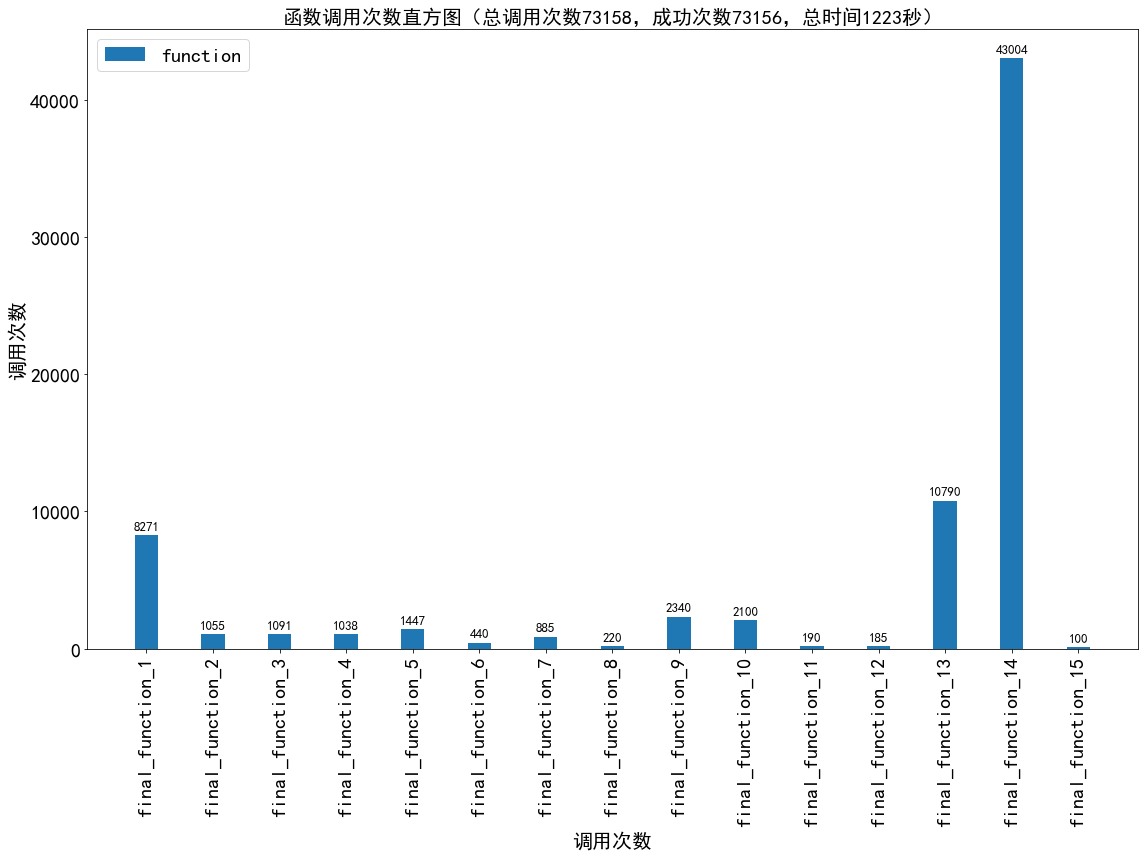

In [5]:
# 共用
width = 0.35  # the width of the bars
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    fontsize=13,
                    textcoords="offset points",
                    ha='center', va='bottom')

# 函数调用次数直方图
labels=[]
values = []
for i in function_analyze_result:
    labels.append(i["function_name"])
    values.append(i["request_num"])
    
x = np.arange(len(labels))  # the label locations

fig, ax = plt.subplots(figsize=(16,12))
rects1 = ax.bar(x, values, width, label='function')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('调用次数', fontsize=20)
ax.set_title(f'函数调用次数直方图（总调用次数{total_request}，成功次数{total_success_request}，总时间{all_time_interval}秒）', fontsize=20)
ax.set_xlabel('调用次数', fontsize=20)
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=90)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax.legend(fontsize=20)

autolabel(rects1)

fig.tight_layout()
plt.savefig(f'{log_name}\\request_num.jpg')
# plt.show()

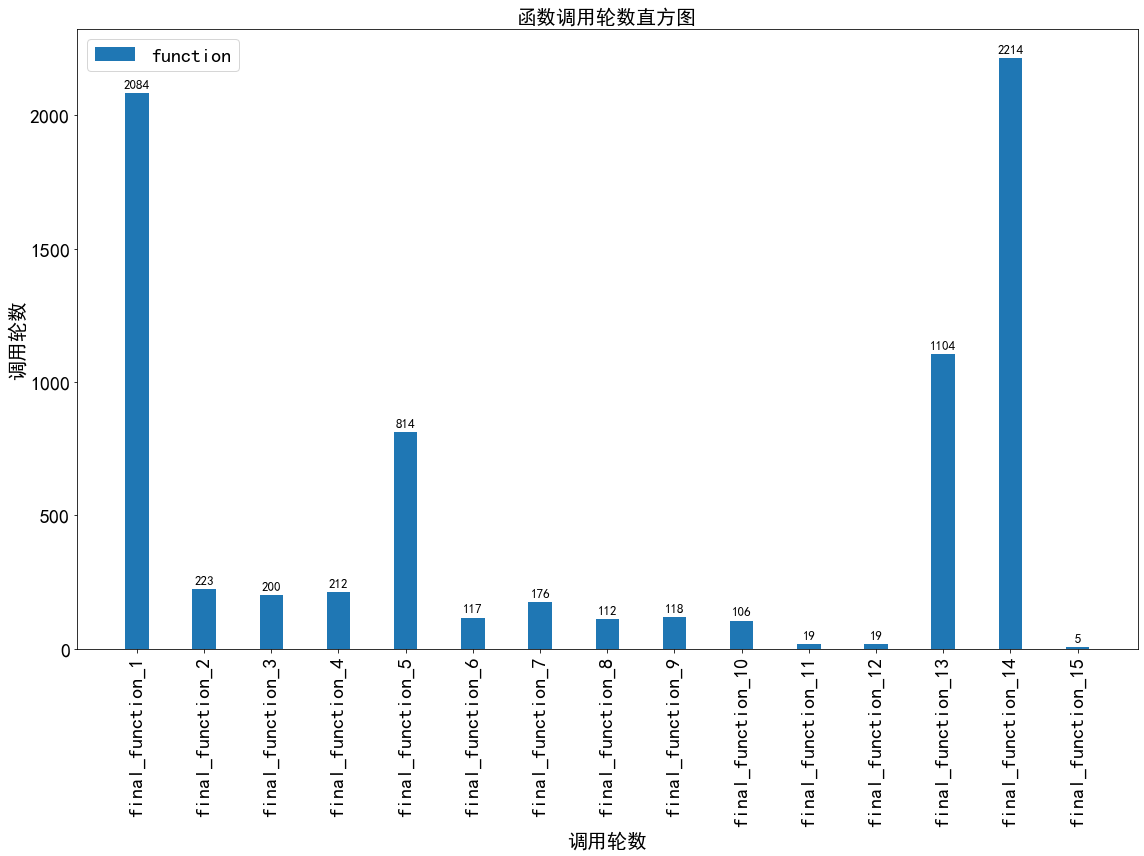

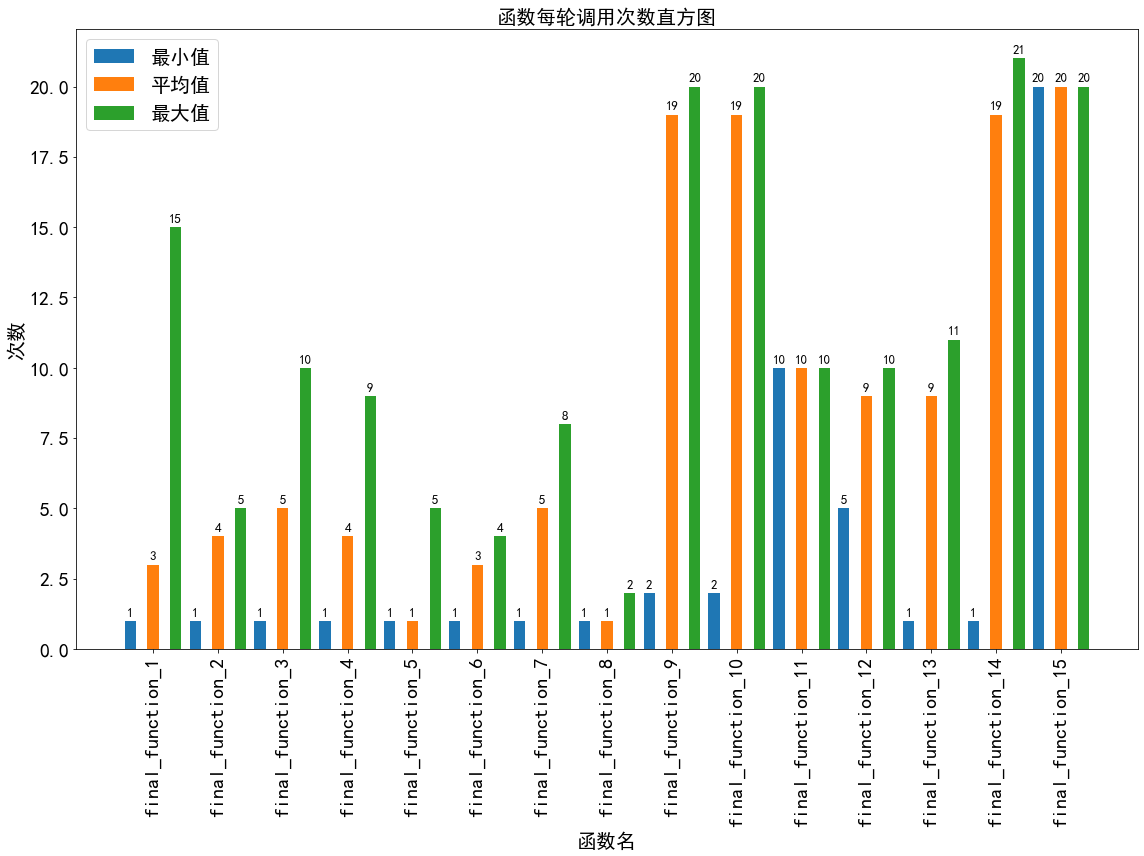

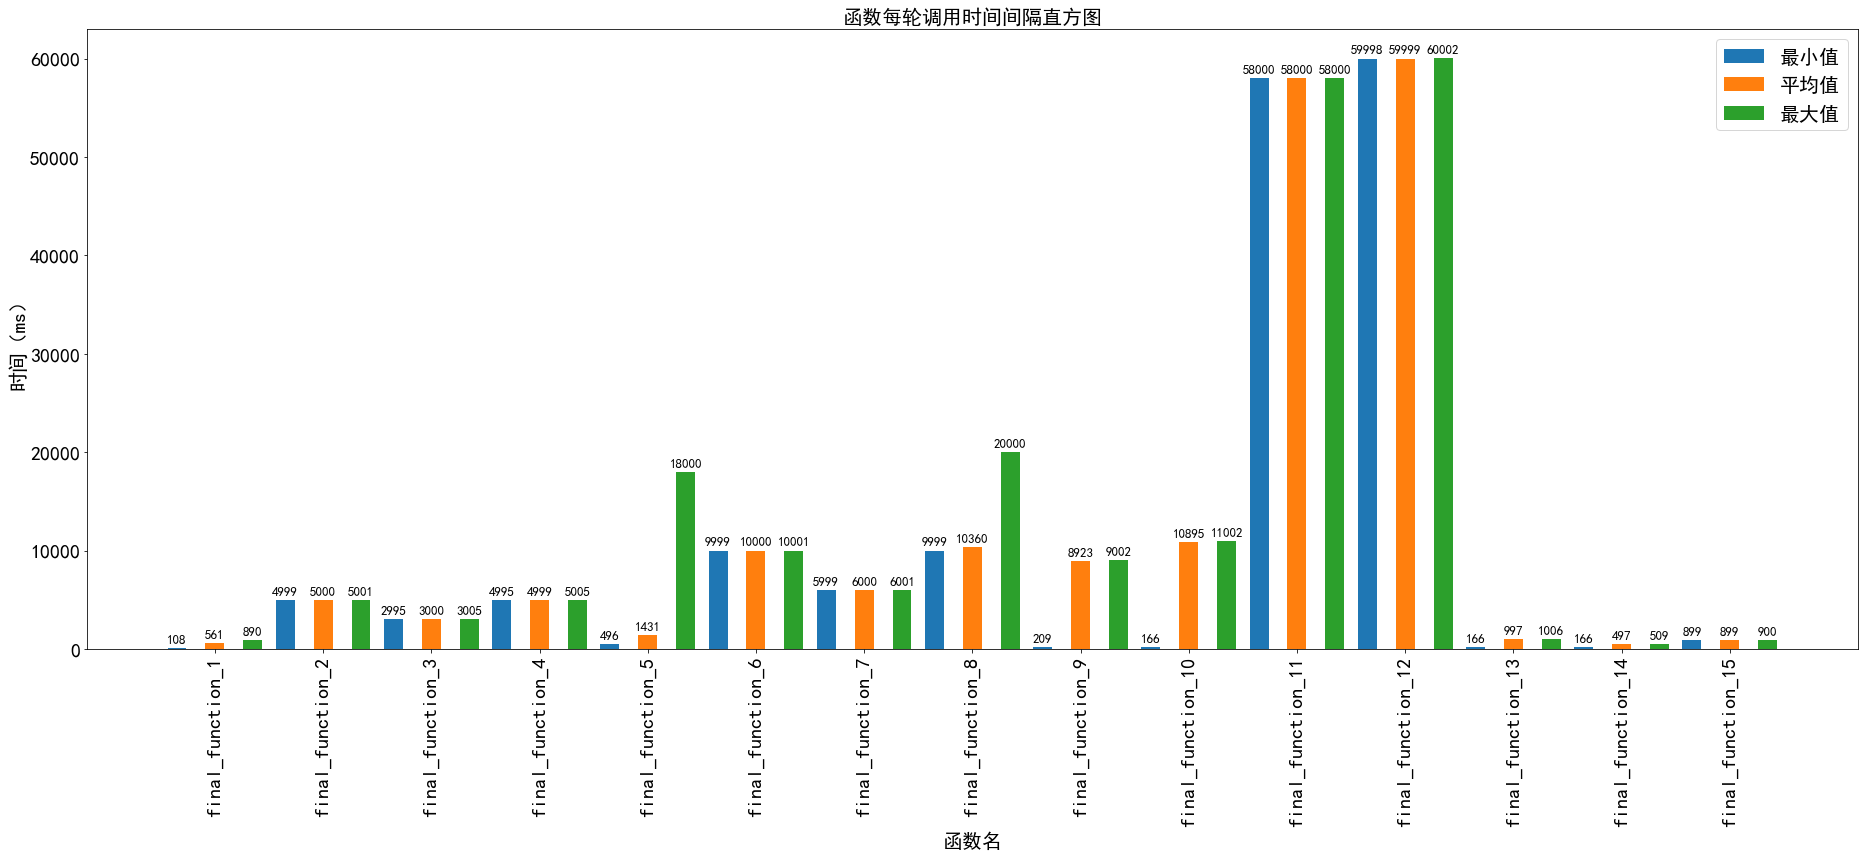

In [6]:
# 函数调用轮数直方图
labels=[]
values = []
for i in function_analyze_result:
    labels.append(i["function_name"])
    values.append(i["request_round"])
    
x = np.arange(len(labels))  # the label locations

fig, ax = plt.subplots(figsize=(16,12))
rects1 = ax.bar(x, values, width, label='function')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('调用轮数', fontsize=20)
ax.set_title(f'函数调用轮数直方图', fontsize=20)
ax.set_xlabel('调用轮数', fontsize=20)
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=90)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax.legend(fontsize=20)

autolabel(rects1)

fig.tight_layout()
plt.savefig(f'{log_name}\\function_request_round.jpg')

# 函数每轮调用次数直方图
labels=[]
min_values = []
mean_values = []
max_values = []

for i in function_analyze_result:
    labels.append(i["function_name"])
    min_values.append(i["min_request_frequency"])
    mean_values.append(i["mean_request_frequency"])
    max_values.append(i["max_request_frequency"])
    
x = np.arange(0, len(labels)*2, 2)  # the label locations

fig, ax = plt.subplots(figsize=(16,12))
rects1 = ax.bar(x - 2*width, min_values, width, label='最小值')
rects2 = ax.bar(x, mean_values, width, label='平均值')
rects3 = ax.bar(x + 2*width, max_values, width, label='最大值')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('次数', fontsize=20)
ax.set_title('函数每轮调用次数直方图', fontsize=20)
ax.set_xlabel('函数名', fontsize=20)
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=90)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax.legend(fontsize=20)

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

fig.tight_layout()
plt.savefig(f'{log_name}\\function_request_frequency.jpg')

# 函数每轮调用时间间隔直方图
labels=[]
min_values = []
mean_values = []
max_values = []

for i in function_analyze_result:
    labels.append(i["function_name"])
    min_values.append(i["min_request_interval"])
    mean_values.append(i["mean_request_interval"])
    max_values.append(i["max_request_interval"])
    
x = np.arange(0, len(labels)*2, 2)  # the label locations

fig, ax = plt.subplots(figsize=(26,12))
rects1 = ax.bar(x - 2*width, min_values, width, label='最小值')
rects2 = ax.bar(x, mean_values, width, label='平均值')
rects3 = ax.bar(x + 2*width, max_values, width, label='最大值')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('时间（ms）', fontsize=20)
ax.set_title('函数每轮调用时间间隔直方图', fontsize=20)
ax.set_xlabel('函数名', fontsize=20)
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=90)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax.legend(fontsize=20)

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

fig.tight_layout()
plt.savefig(f'{log_name}\\function_request_interval.jpg')

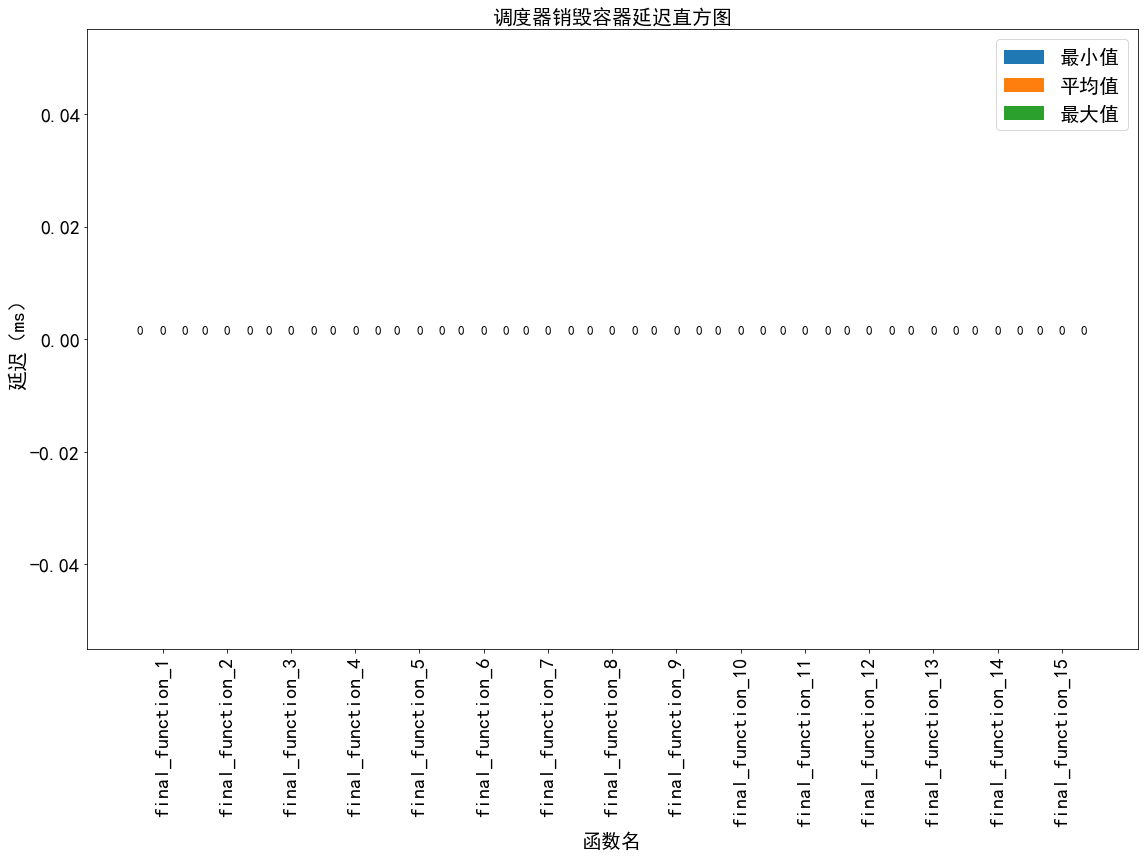

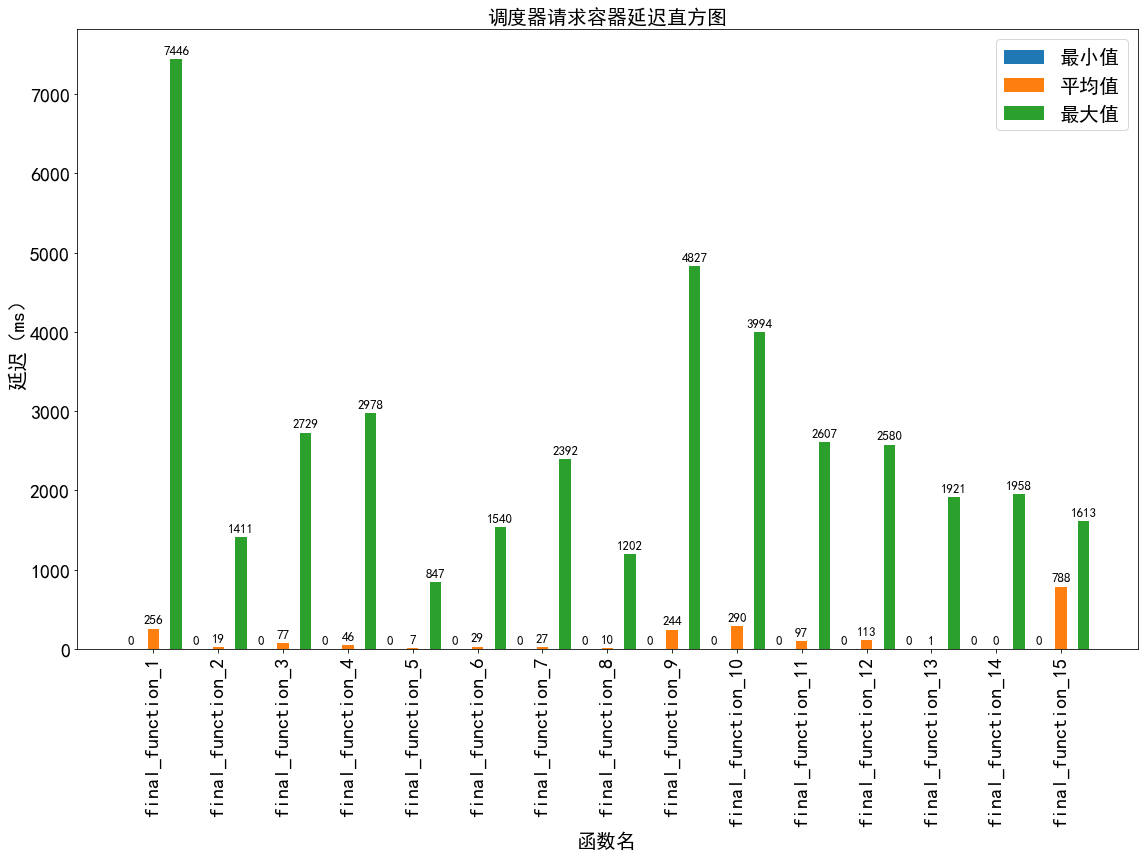

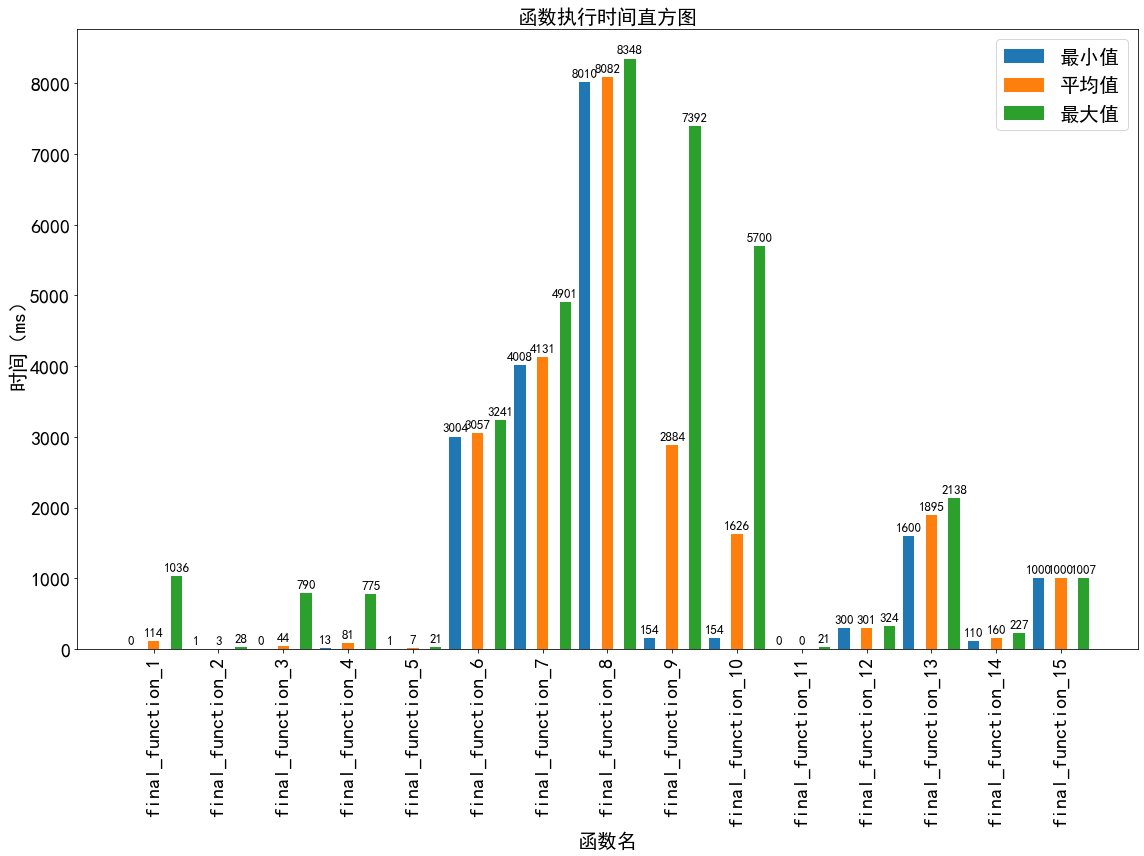

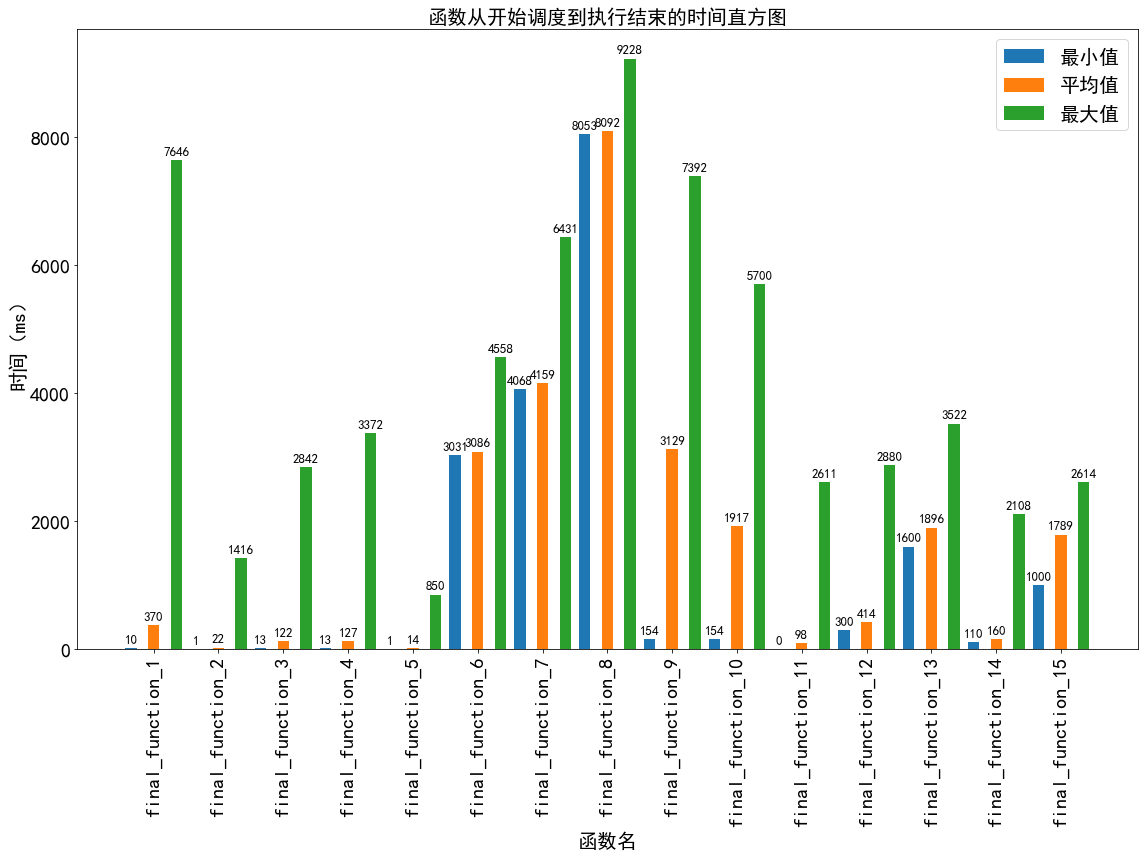

In [7]:
# 调度器销毁容器延迟直方图 （没用了）
labels=[]
min_values = []
mean_values = []
max_values = []

for i in function_analyze_result:
    labels.append(i["function_name"])
    min_values.append(i["min_schedule_return_container_latency"])
    mean_values.append(i["mean_schedule_return_container_latency"])
    max_values.append(i["max_schedule_return_container_latency"])
    
x = np.arange(0, len(labels)*2, 2)  # the label locations

fig, ax = plt.subplots(figsize=(16,12))
rects1 = ax.bar(x - 2*width, min_values, width, label='最小值')
rects2 = ax.bar(x, mean_values, width, label='平均值')
rects3 = ax.bar(x + 2*width, max_values, width, label='最大值')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('延迟（ms）', fontsize=20)
ax.set_title('调度器销毁容器延迟直方图', fontsize=20)
ax.set_xlabel('函数名', fontsize=20)
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=90)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax.legend(fontsize=20)

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

fig.tight_layout()
plt.savefig(f'{log_name}\\schedule_return_container_latency.jpg')
plt.show()

# 调度器请求容器延迟直方图
labels=[]
min_values = []
mean_values = []
max_values = []

for i in function_analyze_result:
    labels.append(i["function_name"])
    min_values.append(i["min_schedule_acquire_container_latency"])
    mean_values.append(i["mean_schedule_acquire_container_latency"])
    max_values.append(i["max_schedule_acquire_container_latency"])
    
x = np.arange(0, len(labels)*2, 2)  # the label locations

fig, ax = plt.subplots(figsize=(16,12))
rects1 = ax.bar(x - 2*width, min_values, width, label='最小值')
rects2 = ax.bar(x, mean_values, width, label='平均值')
rects3 = ax.bar(x + 2*width, max_values, width, label='最大值')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('延迟（ms）', fontsize=20)
ax.set_title('调度器请求容器延迟直方图', fontsize=20)
ax.set_xlabel('函数名', fontsize=20)
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=90)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax.legend(fontsize=20)

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

fig.tight_layout()
plt.savefig(f'{log_name}\\schedule_acquire_container_latency.jpg')
# plt.show()
# 函数执行时间直方图
labels=[]
min_values = []
mean_values = []
max_values = []
for i in function_analyze_result:
    labels.append(i["function_name"])
    min_values.append(i["min_function_execution_duration"])
    mean_values.append(i["mean_function_execution_duration"])
    max_values.append(i["max_function_execution_duration"])
    
x = np.arange(0, len(labels)*2, 2)  # the label locations

fig, ax = plt.subplots(figsize=(16,12))
rects1 = ax.bar(x - 2*width, min_values, width, label='最小值')
rects2 = ax.bar(x, mean_values, width, label='平均值')
rects3 = ax.bar(x + 2*width, max_values, width, label='最大值')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('时间（ms）', fontsize=20)
ax.set_title('函数执行时间直方图', fontsize=20)
ax.set_xlabel('函数名', fontsize=20)
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=90)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax.legend(fontsize=20)

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

fig.tight_layout()
plt.savefig(f'{log_name}\\function_execution_duration.jpg')
# plt.show()

# 函数从开始调度到最终销毁的时间直方图
labels=[]
min_values = []
mean_values = []
max_values = []
for i in function_analyze_result:
    labels.append(i["function_name"])
    min_values.append(i["min_response_time"])
    mean_values.append(i["mean_response_time"])
    max_values.append(i["max_response_time"])
    
x = np.arange(0, len(labels)*2, 2)  # the label locations

fig, ax = plt.subplots(figsize=(16,12))
rects1 = ax.bar(x - 2*width, min_values, width, label='最小值')
rects2 = ax.bar(x, mean_values, width, label='平均值')
rects3 = ax.bar(x + 2*width, max_values, width, label='最大值')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('时间（ms）', fontsize=20)
ax.set_title('函数从开始调度到执行结束的时间直方图', fontsize=20)
ax.set_xlabel('函数名', fontsize=20)
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=90)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax.legend(fontsize=20)

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

fig.tight_layout()
plt.savefig(f'{log_name}\\response_time.jpg')
# plt.show()

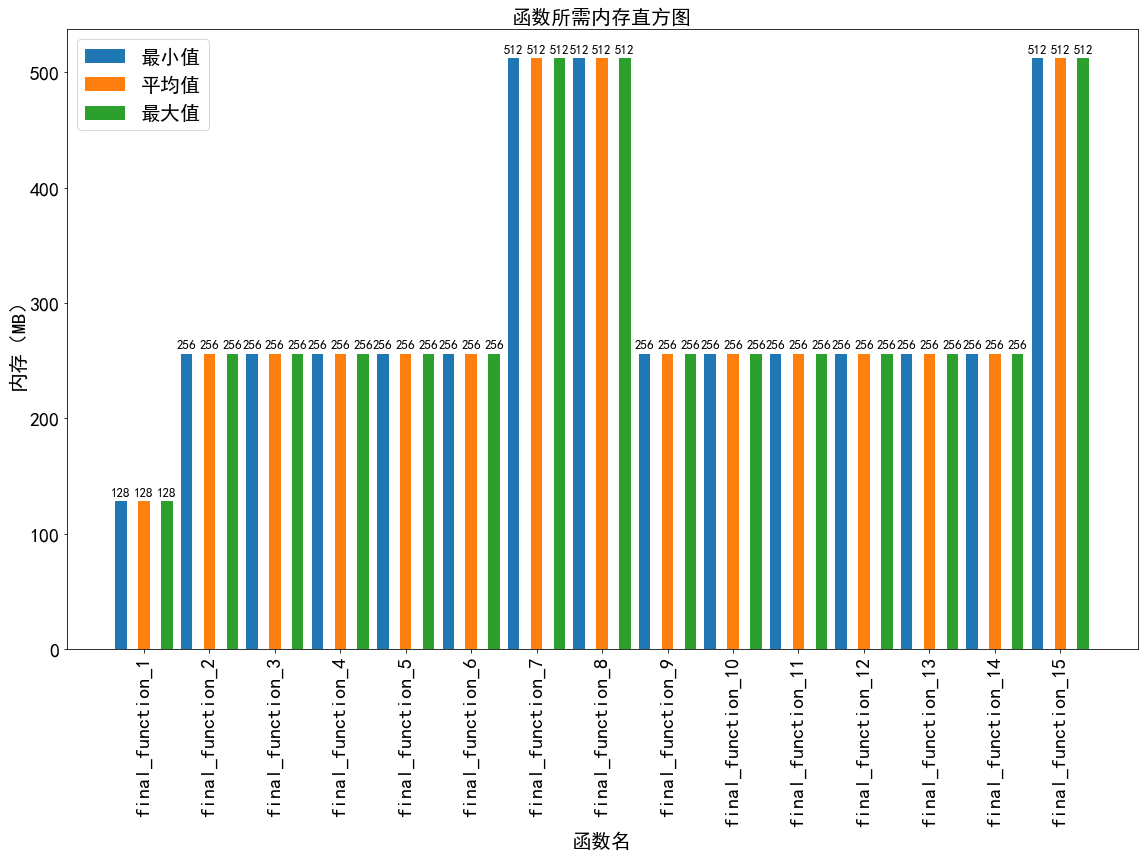

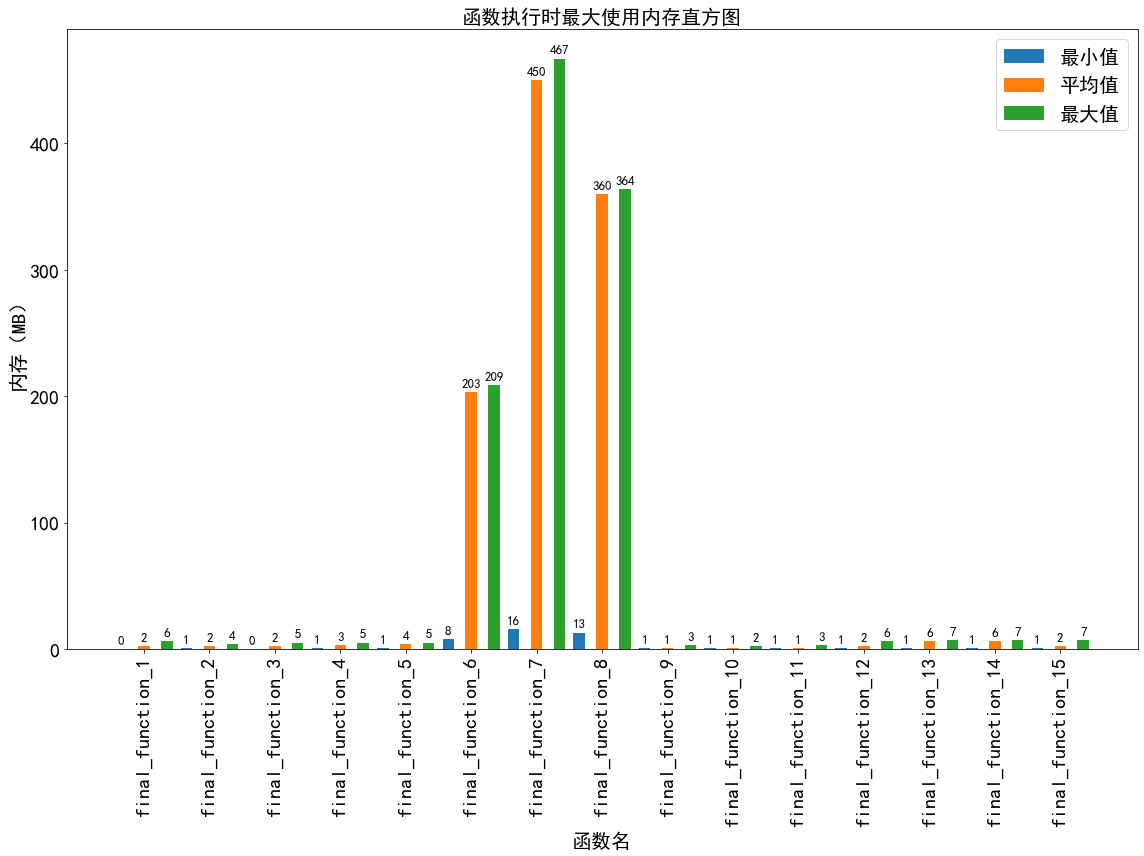

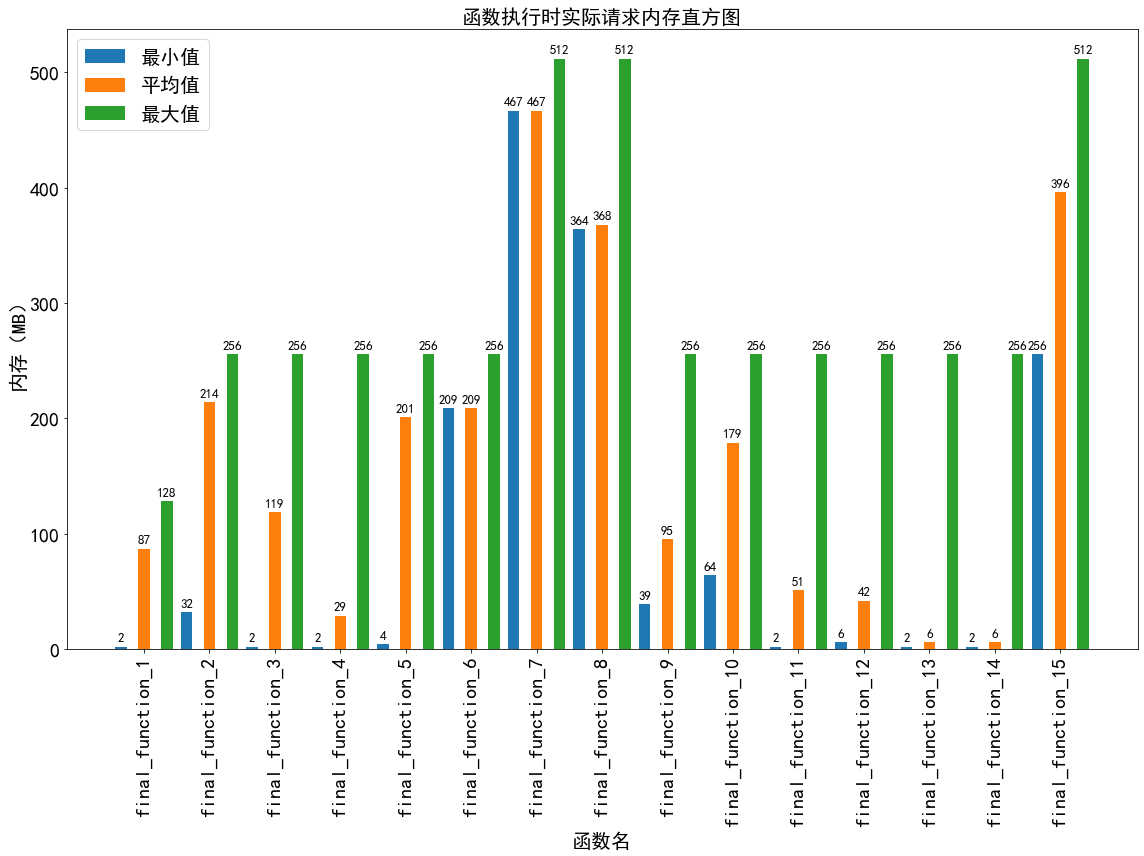

In [8]:
# 函数所需内存直方图
labels=[]
min_values = []
mean_values = []
max_values = []
for i in function_analyze_result:
    labels.append(i["function_name"])
    min_values.append(i["min_require_memory"])
    mean_values.append(i["mean_require_memory"])
    max_values.append(i["max_require_memory"])
    
x = np.arange(0, len(labels)*2, 2)  # the label locations

fig, ax = plt.subplots(figsize=(16,12))
rects1 = ax.bar(x - 2*width, min_values, width, label='最小值')
rects2 = ax.bar(x, mean_values, width, label='平均值')
rects3 = ax.bar(x + 2*width, max_values, width, label='最大值')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('内存（MB）', fontsize=20)
ax.set_title('函数所需内存直方图', fontsize=20)
ax.set_xlabel('函数名', fontsize=20)
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=90)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax.legend(fontsize=20)

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

fig.tight_layout()
plt.savefig(f'{log_name}\\require_memory.jpg')
# plt.show()

# 函数执行时最大使用内存直方图
labels=[]
min_values = []
mean_values = []
max_values = []
for i in function_analyze_result:
    labels.append(i["function_name"])
    min_values.append(i["min_max_memory_usage"])
    mean_values.append(i["mean_max_memory_usage"])
    max_values.append(i["max_max_memory_usage"])
    
x = np.arange(0, len(labels)*2, 2)  # the label locations

fig, ax = plt.subplots(figsize=(16,12))
rects1 = ax.bar(x - 2*width, min_values, width, label='最小值')
rects2 = ax.bar(x, mean_values, width, label='平均值')
rects3 = ax.bar(x + 2*width, max_values, width, label='最大值')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('内存（MB）', fontsize=20)
ax.set_title('函数执行时最大使用内存直方图', fontsize=20)
ax.set_xlabel('函数名', fontsize=20)
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=90)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax.legend(fontsize=20)

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

fig.tight_layout()
plt.savefig(f'{log_name}\\max_memory_usage.jpg')
# plt.show()

# 函数执行时实际请求内存直方图
labels=[]
min_values = []
mean_values = []
max_values = []
for i in function_analyze_result:
    labels.append(i["function_name"])
    min_values.append(i["min_actual_require_memory"])
    mean_values.append(i["mean_actual_require_memory"])
    max_values.append(i["max_actual_require_memory"])
    
x = np.arange(0, len(labels)*2, 2)  # the label locations

fig, ax = plt.subplots(figsize=(16,12))
rects1 = ax.bar(x - 2*width, min_values, width, label='最小值')
rects2 = ax.bar(x, mean_values, width, label='平均值')
rects3 = ax.bar(x + 2*width, max_values, width, label='最大值')
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('内存（MB）', fontsize=20)
ax.set_title('函数执行时实际请求内存直方图', fontsize=20)
ax.set_xlabel('函数名', fontsize=20)
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=90)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax.legend(fontsize=20)

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

fig.tight_layout()
plt.savefig(f'{log_name}\\actual_require_memory.jpg')
# plt.show()

In [ ]:
node_address = []
for i in all_request_dic:
    for j in all_request_dic[i]:
        if j["node_address"] not in node_address:
            node_address.append(j["node_address"])
print(node_address)

In [244]:
a = str({"log":"Time=2020-08-02T00:20:22.451 request id: 1be8e954-392e-449f-827f-f3b64e1e79da, request function name: final_function_1\r\n","stream":"stdout","time":"2020-08-02T00:20:46.193978968Z"}
)
x = 'final_function_1'
pat = re.compile(f'Time=2020-08-02T(.*) request id.*request function name: {x}\\\\r')
print(pat.findall(a))
b = pat.findall(a)[0]
print(b[0:11])
print(b[10:])

['00:20:22.451']
00:20:22.45
51
